In [4]:
#%%
import wandb
from tqdm import tqdm
import torch
import os
import shutil
import matplotlib.pyplot as plt
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy, CategoricalValueNetwork
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
from agents.ppo import PPO as AGENT
import random
import yaml
from devinterp.utils import plot_trace
import pickle
from devinterp.slt.gradient import GradientDistribution
from matplotlib.collections import PatchCollection
import matplotlib.ticker as ticker
from devinterp.slt.norms import GradientNorm
from devinterp.slt.llc import LLCEstimator, OnlineLLCEstimator
from devinterp.slt import sample

plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

# epsilons = np.logspace(-4, -11, 10)
# gammas = np.logspace(1, 6, 10)
# num_chains = 8
# num_draws = 2000

epsilons = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
gammas = [1e3]
num_chains = 3
num_draws = 200
device = "cuda:0"

In [11]:
def plot_trace_and_save(trace, y_axis, name, x_axis='step', title=None, plot_mean=True, plot_std=True, fig_size=(12, 9), true_lc=None):
    num_chains, num_draws = trace.shape
    sgld_step = list(range(num_draws))

    plt.figure(figsize=fig_size)

    if true_lc:
        plt.axhline(y=true_lc, color='r', linestyle='dashed')
    
    # trace
    for i in range(num_chains):
        draws = trace[i]
        plt.plot(sgld_step, draws, linewidth=1, label=f'chain {i}')

    # mean
    if plot_mean:
        mean = np.mean(trace, axis=0)
        plt.plot(sgld_step, mean, color='black', linestyle='--', linewidth=2, label='mean', zorder=3)
    
    # std
    if plot_std:
        std = np.std(trace, axis=0)
        plt.fill_between(sgld_step, mean - std, mean + std, color='gray', alpha=0.3, zorder=2)

    if title is None:
        title = f'{y_axis} values over sampling draws'
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))    
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()
    plt.close()

# def estimate_learning_coeff(
#     model: torch.nn.Module,
#     loader: DataLoader,
#     criterion: Callable,
#     sampling_method: Type[torch.optim.Optimizer] = SGLD,
#     optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
#     num_draws: int = 100,
#     num_chains: int = 10,
#     num_burnin_steps: int = 0,
#     num_steps_bw_draws: int = 1,
#     cores: int = 1,
#     seed: Optional[Union[int, List[int]]] = None,
#     device: torch.device = torch.device("cpu"),
#     verbose: bool = True,
#     callbacks: List[Callable] = [],
# ) -> float:

# og run made with:
# python train.py --exp_name hard-run --env_name maze_aisc --param_name easy --num_levels 0 --distribution_mode easy --num_timesteps 200000000 --num_checkpoints 1000

# Excess defaults from train.py for reference:
#     parser.add_argument('--exp_name',         type=str, default = 'test', help='experiment name')
#     parser.add_argument('--env_name',         type=str, default = 'starpilot', help='environment ID')
#     parser.add_argument('--start_level',      type=int, default = int(0), help='start-level for environment')
#     parser.add_argument('--num_levels',       type=int, default = int(0), help='number of training levels for environment')
#     parser.add_argument('--distribution_mode',type=str, default = 'easy', help='distribution mode for environment')
#     parser.add_argument('--param_name',       type=str, default = 'easy-200', help='hyper-parameter ID')
#     parser.add_argument('--device',           type=str, default = 'gpu', required = False, help='whether to use gpu')
#     parser.add_argument('--gpu_device',       type=int, default = int(0), required = False, help = 'visible device in CUDA')
#     parser.add_argument('--num_timesteps',    type=int, default = int(25000000), help = 'number of training timesteps')
#     parser.add_argument('--seed',             type=int, default = random.randint(0,9999), help='Random generator seed')
#     parser.add_argument('--log_level',        type=int, default = int(40), help='[10,20,30,40]')
#     parser.add_argument('--num_checkpoints',  type=int, default = int(1), help='number of checkpoints to store')

def get_model_number(model_name):
    # model is of format model_<number>:v<version>
    return int(model_name.split('_')[1].split(':')[0])

def gradient_single_plot(gradients, param_name: str, color='blue', plot_zero=True, chain: int = None, filename = None):
    grad_dist = gradients.grad_dists[param_name]
    if chain is not None:
        max_count = grad_dist[chain].max()
    else:
        max_count = grad_dist.sum(axis=0).max()

    def get_color_alpha(count):
        if count == 0:
            return torch.tensor(0).to(gradients.device)
        min_alpha = 0.35
        max_alpha = 0.85
        return (count / max_count) * (max_alpha - min_alpha) + min_alpha
    
    def build_rect(count, bin_min, bin_max, draw):
        alpha = get_color_alpha(count)
        pos = (draw, bin_min)
        height = bin_max - bin_min
        width = 1
        return plt.Rectangle(pos, width, height, color=color, alpha=alpha.cpu().numpy().item(), linewidth=0)
    
    _, ax = plt.subplots()
    patches = []
    for draw in range(gradients.num_draws):
        for pos in range(gradients.num_bins):
            bin_min = gradients.min_grad + pos * gradients.bin_size
            bin_max = bin_min + gradients.bin_size
            if chain is None:
                count = grad_dist[:, draw, pos].sum()
            else:
                count = grad_dist[chain, draw, pos]
            if count != 0:
                rect = build_rect(count, bin_min, bin_max, draw)
                patches.append(rect)
    patches = PatchCollection(patches, match_original=True)
    ax.add_collection(patches)

    # note that these y min/max values are relative to *all* gradients, not just the ones for this param
    y_min = gradients.min_grad
    y_max = gradients.max_grad
    # ensure the 0 line is visible
    y_min = y_min if y_min < 0 else -y_max
    y_max = y_max if y_max > 0 else -y_min
    plt.ylim(y_min, y_max)

    plt.xlim(0, gradients.num_draws)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    if plot_zero:
        plt.axhline(color='black', linestyle=':', linewidth=1)

    plt.xlabel('Sampler steps')
    plt.ylabel('gradient distribution')
    plt.title(f'Distribution of {param_name} gradients at each sampler step')

    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

def get_artifact_network_and_data(artifact_number, datapoints=100, batch_size=100, download=True):
    artifacts = run.logged_artifacts()

    if download:
        artifact = artifacts[artifact_number]
        artifact_to_download = api.artifact(f"{project_name}/{artifact.name}", type="model")
        artifact_dir = artifact_to_download.download()
        model_file = f"{artifact_dir}/{artifact.name[:-3]}.pth"
    else:
        artifacts_file = "artifacts"
        # turn artifacts file into a list of subdirectories
        artifacts = [os.path.join(artifacts_file, name) for name in os.listdir(artifacts_file)]
        # sort
        artifacts.sort()
        # get the artifact we want
        print(len(artifacts))
        artifact_dir = artifacts[artifact_number]
        modelno = get_model_number(artifact_dir)
        print(modelno)
        # exit python
        exit()

    hidden_state_dim = 0
    observation_space = env.observation_space
    observation_shape = observation_space.shape
    storage = Storage(observation_shape, hidden_state_dim, n_steps, n_envs, device)

    loaded_checkpoint = torch.load(model_file)
    model = ImpalaModel(in_channels = observation_shape[0])
    policy = CategoricalPolicy(model, False, env.action_space.n)
    if "state_dict" in loaded_checkpoint:
        policy.load_state_dict(loaded_checkpoint['state_dict'])
    elif "model_state_dict" in loaded_checkpoint:
        policy.load_state_dict(loaded_checkpoint['model_state_dict'])
    policy.to(device)
    agent = AGENT(env, policy, logger, storage, device, num_checkpoints, **hyperparameters)

    dataloader, dataset = agent.generate_data_loader(datapoints, batch_size)
    value_network = CategoricalValueNetwork(model, False)
    if "state_dict" in loaded_checkpoint:
        loaded_checkpoint['state_dict'] = {k: v for k,v in loaded_checkpoint['state_dict'].items() if "policy" not in k}
        value_network.load_state_dict(loaded_checkpoint['state_dict'])
    elif "model_state_dict" in loaded_checkpoint:
        loaded_checkpoint['model_state_dict'] = {k: v for k,v in loaded_checkpoint['model_state_dict'].items() if "policy" not in k}
        value_network.load_state_dict(loaded_checkpoint['model_state_dict'])
    return dataloader, dataset, value_network

def optimize_value_network(value_network, dataloader, epochs=50, lr=1e-5):
    value_network.to(device)
    optimizer = torch.optim.Adam(value_network.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    # Initialize a new wandb run
    wandb.init(
        project="procgen-lambdahat-estimation", 
        name="optimize_that_thing!", 
        mode="offline"
    )

    for epoch in tqdm(range(epochs)):
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()
            observations, returns = batch
            observations = observations.to(device)
            returns = returns.to(device)
            values_pred = value_network(observations)
            value_loss = criterion(values_pred, returns)

            value_loss.backward()
            optimizer.step()

            # Calculate gradients statistics
            grad_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()) for p in value_network.parameters() if p.grad is not None]))
            grad_mean = torch.mean(torch.stack([torch.mean(p.grad.detach()) for p in value_network.parameters() if p.grad is not None]))
            grad_std = torch.std(torch.stack([torch.std(p.grad.detach()) for p in value_network.parameters() if p.grad is not None]))

            # Log the loss and gradients
            wandb.log({
                "epoch": epoch,
                "batch": batch_idx,
                "value_loss": value_loss.item(),
                "value_network_grad_norm": grad_norm, 
                "value_network_grad_mean": grad_mean, 
                "value_network_grad_std": grad_std,
                **{f"gradients/{name}": wandb.Histogram(p.grad.cpu().numpy()) for name, p in value_network.named_parameters() if p.grad is not None}
            })

    wandb.finish()
    return value_network    
criterion = torch.nn.MSELoss()

def run_callbacks(model, epsilon, gamma, dataloader, num_chains, num_draws, dataset, callbacks, device):
    optim_kwargs = {
        "lr": epsilon,
        "elasticity": gamma,
        "temperature": "adaptive",
        "num_samples": len(dataset), 
        "save_noise": True
    }
    
    if callbacks is None:
        llc_estimator = OnlineLLCEstimator(num_chains, num_draws, len(dataset), device=device)
        callbacks = [llc_estimator]

    sample(
        model=model, 
        loader=dataloader, 
        criterion = criterion, 
        optimizer_kwargs = optim_kwargs,
        sampling_method = SGLD, 
        num_chains = num_chains,
        num_draws = num_draws, 
        callbacks = callbacks, 
        device=device
    )
    
    results = {}

    for callback in callbacks:
        if hasattr(callback, "sample"):
            results.update(callback.sample())
    return results
    

def estimate_llcs_sweeper(model, epsilons, gammas, dataloader, dataset):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            print(f"epsilon: {epsilon}, gamma: {gamma}, model 8000")
            optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                elasticity=gamma,
                num_samples=len(dataset),
                temperature="adaptive",
            )
            pair = (epsilon, gamma)
            # try:
            grad_norm = GradientNorm(
                num_chains = num_chains, 
                num_draws = num_draws, 
                device=device
            )
            llc_estimater = LLCEstimator(
                num_chains = num_chains,
                num_draws = num_draws, 
                device = device
            )
            callbacks = [llc_estimater, grad_norm]
            results[pair] = run_callbacks(
                train_loader=dataloader,
                train_data=dataset, 
                weights = model.parameters(),
                criterion=criterion,

                
            )
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=dataloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=num_chains,
                num_draws=num_draws,
                device=device,
                online=True,
                callbacks=callbacks
            )
            # except:
            #     print("failed")
            #     results[pair] = None
    return results

def plot_single_graph(result, filename=None, title=''):
    llc_color = 'teal'
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result['loss/trace']
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result['llc/means']
    stds = result['llc/stds']
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx() 
    axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
    axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel('SGLD time step')
    axs.set_ylabel('loss')
    axs2.set_ylabel('llc', color=llc_color)
    axs2.tick_params(axis='y', labelcolor=llc_color)
    axs.axhline(color='black', linestyle=':')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

def plot_sweep_single_model(results, epsilons, gammas, filename, **kwargs):
    llc_color = 'teal'
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            if result is None:
                continue
            # plot loss traces
            loss_traces = result['loss/trace']
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result['llc/means']
            stds = result['llc/stds']
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx() 
            axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
            axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)
            
            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel('SGLD time step')
            axs[i, j].set_ylabel('loss')
            axs2.set_ylabel('llc', color=llc_color)
            axs2.tick_params(axis='y', labelcolor=llc_color)
    if kwargs['title']:
        fig.suptitle(kwargs['title'], fontsize=16)
    plt.tight_layout()
    plt.savefig(filename)

In [6]:
# Set your specific run ID here
run_id = "jp9tjfzd"
project_name = "procgen"

# Initialize wandb API
api = wandb.Api()

# Fetch the run
run = api.run(f"{project_name}/{run_id}")

torch.manual_seed(1)

####################
## HYPERPARAMETERS #
#################### 
param_name = 'easy'
gpu_device = int(0)
env_name = "maze_aisc"
start_level = 0
num_levels = 0
distribution_mode = "easy"
exp_name = "hard-run"
seed = random.randint(0,9999)
num_checkpoints = 0

print('[LOADING HYPERPARAMETERS...]')
with open('hyperparams/procgen/config.yml', 'r') as f:
    hyperparameters = yaml.safe_load(f)[param_name]
for key, value in hyperparameters.items():
    print(key, ':', value)

############
## DEVICE ##
############
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
device = torch.device('cuda')

#################
## ENVIRONMENT ##
#################
print('INITIALIZAING ENVIRONMENTS...')
n_steps = hyperparameters.get('n_steps', 256)
n_envs = hyperparameters.get('n_envs', 64)
# By default, pytorch utilizes multi-threaded cpu
# Procgen is able to handle thousand of steps on a single core
torch.set_num_threads(1)
env = ProcgenEnv(num_envs=n_envs,
                    env_name=env_name,
                    start_level=start_level,
                    num_levels=num_levels,
                    distribution_mode=distribution_mode, 
                    rand_region = 5) 
normalize_rew = hyperparameters.get('normalize_rew', True)
env = VecExtractDictObs(env, "rgb")
if normalize_rew:
    env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

############
## LOGGER ##
############
print('INITIALIZAING LOGGER...')
logdir = 'procgen/' + env_name + '/' + exp_name + '/' + 'seed' + '_' + \
            str(seed) + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('logs', logdir)
if not (os.path.exists(logdir)):
    os.makedirs(logdir)
logger = Logger(n_envs, logdir)


[LOADING HYPERPARAMETERS...]
algo : ppo
n_envs : 64
n_steps : 256
epoch : 3
mini_batch_per_epoch : 8
mini_batch_size : 2048
gamma : 0.999
lmbda : 0.95
learning_rate : 0.0005
grad_clip_norm : 0.5
eps_clip : 0.2
value_coef : 0.5
entropy_coef : 0.01
normalize_adv : True
normalize_rew : True
use_gae : True
architecture : impala
recurrent : False
INITIALIZAING ENVIRONMENTS...
building procgen...done
INITIALIZAING LOGGER...


In [52]:
artifact_no = 8000
print(f"Fetching model and dataloader {artifact_no}")
dataloader, dataset, value_network = get_artifact_network_and_data(
    artifact_number = artifact_no, 
    datapoints = 4000, 
    batch_size = 1000, 
    download=True
)
print(len(dataset))
print(f"Optimizing value network {artifact_no}")
value_network = optimize_value_network(value_network, dataloader, epochs=200)
torch.save(value_network.state_dict(), f'value_network_local_min_{artifact_no}.pth')

# print layers of value network
for name, param in value_network.named_parameters():
    print(name, param.shape)

Fetching model and dataloader 8000


wandb:   1 of 1 files downloaded.  


Observation tensor size: torch.Size([3968, 3, 64, 64])
Reward tensor size: torch.Size([3968])
3968
Optimizing value network 8000


100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
value_loss,██▇▇▆▆▅▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
value_network_grad_mean,██▇▇▇▆▆▅▄▃▃▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
value_network_grad_norm,▇▇▇▇▇▇█████▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,3
epoch,199
value_loss,0.91388
value_network_grad_mean,-0.00555
value_network_grad_norm,3.84389
value_network_grad_std,nan


embedder.block1.conv.weight torch.Size([16, 3, 3, 3])
embedder.block1.conv.bias torch.Size([16])
embedder.block1.res1.conv1.weight torch.Size([16, 16, 3, 3])
embedder.block1.res1.conv1.bias torch.Size([16])
embedder.block1.res1.conv2.weight torch.Size([16, 16, 3, 3])
embedder.block1.res1.conv2.bias torch.Size([16])
embedder.block1.res2.conv1.weight torch.Size([16, 16, 3, 3])
embedder.block1.res2.conv1.bias torch.Size([16])
embedder.block1.res2.conv2.weight torch.Size([16, 16, 3, 3])
embedder.block1.res2.conv2.bias torch.Size([16])
embedder.block2.conv.weight torch.Size([32, 16, 3, 3])
embedder.block2.conv.bias torch.Size([32])
embedder.block2.res1.conv1.weight torch.Size([32, 32, 3, 3])
embedder.block2.res1.conv1.bias torch.Size([32])
embedder.block2.res1.conv2.weight torch.Size([32, 32, 3, 3])
embedder.block2.res1.conv2.bias torch.Size([32])
embedder.block2.res2.conv1.weight torch.Size([32, 32, 3, 3])
embedder.block2.res2.conv1.bias torch.Size([32])
embedder.block2.res2.conv2.weight t

In [53]:
from devinterp.slt.callback import validate_callbacks

In [61]:
# epsilons = [1e-8, 1e-9, 1e-10, 1e-11]
# gammas = [1.0, 10, 100, 1000, 10000, 100000]
epsilons = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
gammas = [1e1, 1e2]
num_chains = 3
num_draws = 25

In [62]:
print(f"Running calibration sweep on model {artifact_no}")
# results = estimate_llcs_sweeper(value_network, epsilons, gammas, dataloader, dataset)

results = {}
timed_dir = f"calibration_sweeps/{str(time.time())}"
os.makedirs(timed_dir, exist_ok=True)
for epsilon in epsilons:
    for gamma in gammas:
        llc_estimator = OnlineLLCEstimator(num_chains, num_draws, len(dataset), device=device)
        grad_norm = GradientNorm(num_chains, num_draws, device=device)
        callbacks = [grad_norm, llc_estimator]
        print(validate_callbacks(callbacks))
        result = run_callbacks(
            model=value_network,
            epsilon=epsilon,
            gamma=gamma,
            dataloader=dataloader,
            num_chains=num_chains,
            num_draws=num_draws,
            dataset=dataset,
            callbacks=callbacks,
            device=device
        )
        print(epsilon, gamma)
        results[(epsilon, gamma)] = result
        plot_single_graph(result)
        with open(f'{timed_dir}/calibration_sweep_results_model_{artifact_no}.pkl', 'wb') as f:
            pickle.dump(results, f)


# print("Fetching model and dataloader 100")
# dataloader, dataset, value_network = get_artifact_network_and_data(artifact_number = 100)

# print("Running calibration sweep on model 100")
# results = estimate_llcs_sweeper(value_network, epsilons, gammas)

# with open('calibration_sweep_results_model_100.pkl', 'wb') as f:
#     pickle.dump(results, f)

# plot_sweep_single_model(
#     results, 
#     epsilons, 
#     gammas, 
#     "calibration_sweep_model_100.png", 
#     title='Calibration sweep of model for lr ($\epsilon$) and elasticity ($\gamma$)'
# )


Running calibration sweep on model 8000
True


Chain 0:   4%|▍         | 1/25 [00:00<00:02,  8.34it/s]

Chain 1:  40%|████      | 10/25 [00:01<00:01,  9.66it/s]

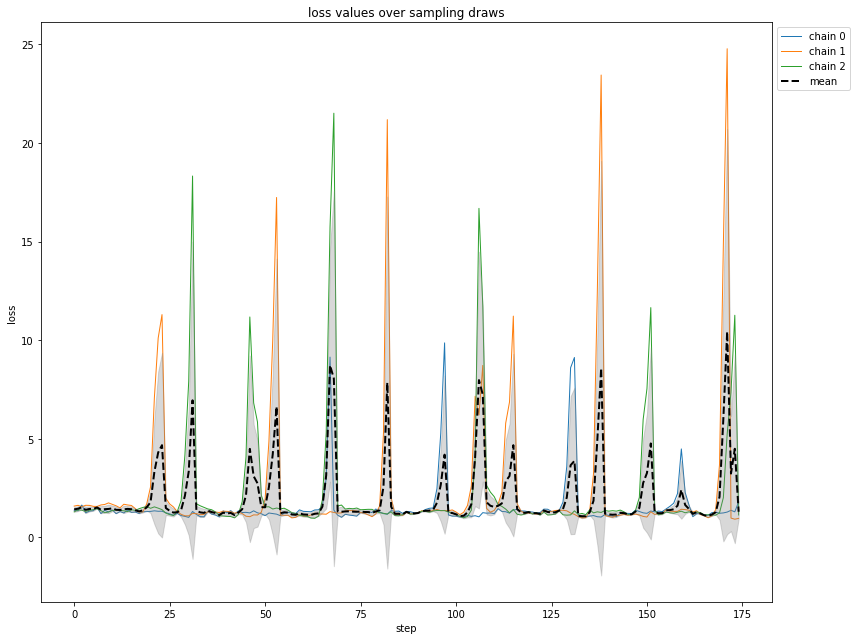

(3, 200)


In [ ]:
result = results[(1e-06, 100000.0)]
loss_trace = result["loss/trace"]
llc_trace = result["llc/trace"]
# grad_trace = result["grad_norm/trace"]
plot_trace_and_save(
    loss_trace, 
    y_axis='loss', 
    name='loss_trace.png', 
    plot_mean=True, 
    plot_std=True, 
    true_lc=None
)
print(loss_trace.shape)

In [28]:
with open(f'{timed_dir}/calibration_sweep_results_model_{artifact_no}.pkl', 'rb') as f:
    results = pickle.load(f)
folder_timelog = str(time.time())
os.makedirs(f"calibration_sweep/{folder_timelog}", exist_ok=True)

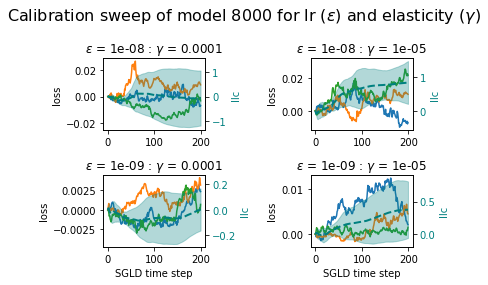

In [29]:
plot_sweep_single_model(
    results, 
    epsilons, 
    gammas, 
    f"calibration_sweep_model_{artifact_no}.png", 
    title=f'Calibration sweep of model {artifact_no} for lr ($\epsilon$) and elasticity ($\gamma$)'
)

In [2]:
for epsilon in epsilons:
    for gamma in gammas:
        llc_trace = results[(epsilon, gamma)]['llc/trace']
        # plot_trace(llc_trace, f'llc_trace ({epsilon}, {gamma})', f"calibration_sweep/{folder_timelog}/llc_trace.png")
        # # gradient_trace = results[(epsilon, gamma)]['gradient_norm/trace']
        # # plot_trace(gradient_trace, f'gradient_trace ({epsilon}, {gamma})', f"calibration_sweep/{folder_timelog}/gradient_trace.png")
        # loss_trace = results[(epsilon, gamma)]['loss/trace']
        # plot_trace(loss_trace, f'loss_trace ({epsilon}, {gamma})', f"calibration_sweep/{folder_timelog}/loss_trace.png")
        plot_single_graph(results[(epsilon, gamma)])

NameError: name 'epsilons' is not defined

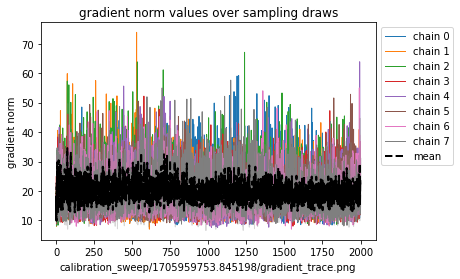

<Figure size 864x648 with 0 Axes>

In [27]:
gradient_trace = result['gradient_norm/trace']
plot_trace(gradient_trace, 'gradient norm', f"calibration_sweep/{folder_timelog}/gradient_trace.png")

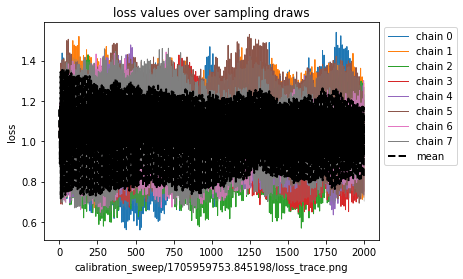

<Figure size 864x648 with 0 Axes>

In [28]:
loss_trace = result['loss/trace']
plot_trace(loss_trace, 'loss', f"calibration_sweep/{folder_timelog}/loss_trace.png")

In [ ]:
with open('calibration_sweep_results_model_8000.pkl', 'rb') as f:
    results = pickle.load(f)
folder_timelog = str(time.time())
os.makedirs(f"calibration_sweep/{folder_timelog}", exist_ok=True)
for epsilon in epsilons:
    for gamma in gammas:
        result = results[(epsilon, gamma)]
        if result is None:
            continue
        
        plot_single_graph(
            result, 
            f"calibration_sweep/{folder_timelog}/llc_model_8000_{epsilon}_{gamma}.png",
            title=f"Calibration sweep of model 8000 for lr ($\epsilon$) and elasticity ($\gamma$)"
        )

        gradient_trace = result["gradient_norm/trace"]
        plot_trace_and_save(
            gradient_trace, 
            y_axis="gradient norm", 
            name=f"calibration_sweep/{folder_timelog}/gradient_trace_model_8000_{epsilon}_{gamma}.png"
        )